# PROJECT | Natural Language Processing Challenge

## Phase 1: Data Loading and Exploration

### Import Libraries & NLTK Setup

In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy.sparse import hstack

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lain\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [56]:
import joblib

### Load and Read dataset

In [8]:
df = pd.read_csv('./dataset/data.csv', encoding="ISO-8859-1")
df['combined'] = df['title'] + " " + df['text']
y = df['label']
df = df.drop(columns=['label', 'title', 'text', 'date'])

### Split train and test before any preprocessing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

## Phase 2: Text Preprocessing

### Apply data preprocessing & Hot encoding

#### Define Cleaning Function

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    return ' '.join(tokens)

In [11]:
X_train['clean_combined'] = X_train['combined'].apply(preprocess_text)
X_test['clean_combined'] = X_test['combined'].apply(preprocess_text)

#### Hot encoding Subject

In [ ]:
# Hot encoding subject on both train and test
subject_dummies_train = pd.get_dummies(X_train['subject'], prefix='subject', dtype=int)
subject_dummies_test = pd.get_dummies(X_test['subject'], prefix='subject', dtype=int)

#### Reindex():
After splitting the data, some categories in the subject column may only appear in the training set and not in the test set (or the other way around).
Because pd.get_dummies() generates columns based on the values it sees, train and test might end up with different sets of columns.
To fix this, we use .reindex() on the test set to match the training columns and fill any missing ones with 0.

QUESTION: should'nt we do hot encoding before splitting so we dont lose any categories?

In [13]:
# Align test columns with train
subject_dummies_test = subject_dummies_test.reindex(columns=subject_dummies_train.columns, fill_value=0)

In [14]:
X_train = pd.concat([X_train.drop(columns=['subject', 'combined']), subject_dummies_train], axis=1)
X_test = pd.concat([X_test.drop(columns=['subject', 'combined']), subject_dummies_test], axis=1)

In [15]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (31953, 7)
X_test shape:  (7989, 7)


In [16]:
X_train.head()

,clean_combined,subject_Government News,subject_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews
38232,mn mayor candid want disarm cop muslim cop kil...,0,0,1,0,0,0
17455,china confirm amend parti constitut like inclu...,0,0,0,0,0,1
15433,saudi mass arrest jolt market mani see overdu ...,0,0,0,0,0,1
30412,watch stonefac anderson cooper get school trum...,0,0,0,1,0,0
22452,let fake news trump troll hard swedish newspap...,0,1,0,0,0,0


In [18]:
X_test.head()

,clean_combined,subject_Government News,subject_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews
6524,oil busi seen strong posit trump tackl tax ref...,0,0,0,0,1,0
30902,whoa colleg snowflak freak scream two minut tr...,0,0,0,1,0,0
36459,croni corrupt polit obama admin block fbi clin...,1,0,0,0,0,0
9801,cruz campaign vet fiorina possibl vp pick abc ...,0,0,0,0,1,0
25638,minnesota woman write amaz fck letter men want...,0,1,0,0,0,0


## Phase 3: Feature Engineering

### TF-IDF Vectorization

- Fitting (only on train): learn vocab and calculates the punctuations TF-IDF only on train
- Transform: generates a matrix with TF-IDF values 


-> fit_transform(): Learn vocab + generates matrix

In [19]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_text = tfidf.fit_transform(X_train['clean_combined'])

Steps:
- cross validation: 
- change some feature (date, subject) -> 
- vectorizer Grid Search

1. cross validation (not deep learning) 
2. (if 1 good) grid search - hyper param search
3. (if 1 bad) change features 

starndard dev :  avg scor eof review - distriib stars  low dev: 

Saving Vectorizer

In [ ]:
joblib.dump(tfidf, './models/tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

- Transform on Test data generating a numerical matrix.It applies the vocabulary already learned in the previous step
 

In [20]:
X_test_text = tfidf.transform(X_test['clean_combined'])

Visualize the Matrix: convert it first to Dataframe

In [39]:
# Obtain vocab
feature_names = tfidf.get_feature_names_out()
# convert to df
df_tfidf = pd.DataFrame(X_train_text.toarray(), columns=feature_names)
df_tfidf.head()

,abandon,abba,abc,abc news,abdullah,abe,abedin,abid,abil,abl,...,younger,your,youth,youtub,zealand,zero,zika,zimbabw,zone,zuma
0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0329,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Visualize first 10 most relevant words (most weighted by tf-idf) in news number 333

In [42]:
df_tfidf.iloc[333].sort_values(ascending=False).head(10)

snyder      0.425841
gun         0.327989
owner       0.258783
flint       0.251868
zone        0.195507
carri       0.175167
water       0.169734
michigan    0.155864
conceal     0.149636
bill        0.143547
Name: 333, dtype: float64

In [21]:
# Now we only need the subjects one hot encoded columns
X_train_other = X_train.drop(columns=['clean_combined'])
X_test_other = X_test.drop(columns=['clean_combined'])

Now, before training with RandomForest, we need to combine both Features (train set text (X_train_text) with train hot encoded subjects (X_train_other)). The problem is that X_train_text is a matrix and X_train_subjects is a Dataframe.  
- X_train_text is a sparse matrix (lightweight)
- X_train_other.values is a dense matrix (0/1 values)

In [32]:
# Combine TF-IDF vectors with one-hot features
X_train_final = hstack([X_train_text, X_train_other.values])
X_test_final = hstack([X_test_text, X_test_other.values])

Visualize X_train_final matrix: Convert to DF 
1. We have the vocabulary in feature_names, however this has only the text+title columns, we do not have the subject columns there
2. Add name to all columns using feature_names + X_Train_other colums
3. Convert to DF

Like this we can see the final X_train dataframe with all the features (title + text + subject)

In [43]:
all_feature_names = list(feature_names) + list(X_train_other.columns)
df_final_tfidf = pd.DataFrame(X_train_final.toarray(), columns=all_feature_names)
df_final_tfidf.head()

,abandon,abba,abc,abc news,abdullah,abe,abedin,abid,abil,abl,...,zika,zimbabw,zone,zuma,subject_Government News,subject_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews
0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0329,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Phase 4: Model Training, Prediction & Evaluation

- Number of trees to form the forest = 100
- max_depth of each tree = 25 (if its not controlled it can grow too much and give us overfitting)
- jobs -1 : use all available cpu nuclis paralel computing

In [46]:
model = RandomForestClassifier(n_estimators=100, max_depth=25, n_jobs=-1, random_state=42)
model.fit(X_train_final, y_train)

RandomForestClassifier(max_depth=25, n_jobs=-1, random_state=42)

Saving model

In [ ]:
joblib.dump(model, './models/random_forest_model.pkl')

['random_forest_model.pkl']

In [47]:
y_pred = model.predict(X_test_final)

In [50]:
X_test_final

<7989x5006 sparse matrix of type '<class 'numpy.float64'>'
	with 1147233 stored elements in COOrdinate format>

In [49]:
y_pred

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [48]:
print(" Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

 Accuracy: 0.9991237952184253
Confusion Matrix:
 [[3991    5]
 [   2 3991]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3996
           1       1.00      1.00      1.00      3993

    accuracy                           1.00      7989
   macro avg       1.00      1.00      1.00      7989
weighted avg       1.00      1.00      1.00      7989



this report is too good to be true

In [51]:
results = pd.DataFrame({
    'text': X_test['clean_combined'],
    'actual_label': y_test.values,
    'predicted_label': y_pred
})
results.head(10)

,text,actual_label,predicted_label
6524,oil busi seen strong posit trump tackl tax ref...,1,1
30902,whoa colleg snowflak freak scream two minut tr...,0,0
36459,croni corrupt polit obama admin block fbi clin...,0,0
9801,cruz campaign vet fiorina possibl vp pick abc ...,1,1
25638,minnesota woman write amaz fck letter men want...,0,0
19297,german polit rival agre lotteri berlin reuter ...,1,1
6604,trump discuss mideast peac call egypt sisi reu...,1,1
20563,trump crush exkkk leader bash final call white...,0,0
26826,donald war crimin rumsfeld take moment remind ...,0,0
19757,exclus kill rohingya villag myanmar beg safe p...,1,1


## Phase 5: Validation and Prediction

Load model and vectorizer

In [ ]:
model = joblib.load('./models/random_forest_model.pkl')
tfidf = joblib.load('./models/tfidf_vectorizer.pkl')

We apply the same steps on the validation data set 

In [ ]:
# Load data model
df_val = pd.read_csv('./dataset/validation_data.csv', encoding="ISO-8859-1")

# Data Preprocessing
df_val['combined'] = df_val['title'] + df_val['text']
df_val['clean_combined'] = df_val['combined'].apply(preprocess_text)

subject_encoding_val = pd.get_dummies(df_val['subject'], prefix='subject', dtype=int)
subject_encoding_val = subject_encoding_val.reindex(columns=subject_dummies_train.columns, fill_value=0)

# transform 
X_val_text = tfidf.transform(df_val['clean_combined'])
X_val_final = hstack([X_val_text, subject_encoding_val.values])

In [63]:
preds = model.predict(X_val_final)

In [64]:
df_val['label'] = preds

In [65]:
df_val_final = df_val[['label', 'title', 'text', 'subject', 'date']]

In [66]:
df_val_final.head()

,label,title,text,subject,date
0,1,UK's May 'receiving regular updates' on London...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 15, 2017"
1,1,UK transport police leading investigation of L...,LONDON (Reuters) - British counter-terrorism p...,worldnews,"September 15, 2017"
2,1,Pacific nations crack down on North Korean shi...,WELLINGTON (Reuters) - South Pacific island na...,worldnews,"September 15, 2017"
3,1,Three suspected al Qaeda militants killed in Y...,"ADEN, Yemen (Reuters) - Three suspected al Qae...",worldnews,"September 15, 2017"
4,1,Chinese academics prod Beijing to consider Nor...,BEIJING (Reuters) - Chinese academics are publ...,worldnews,"September 15, 2017"


In [67]:
df_val_final.to_csv('predictions_validation.csv', index=False)

## Phase 6: Cross-Validation

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)), 'clean_combined'),
        ('subject', OneHotEncoder(handle_unknown='ignore'), ['subject'])
    ]
)

In [20]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=25,  n_jobs=-1))
])

In [21]:
import numpy as np

df_full = pd.read_csv('./dataset/data.csv', encoding="ISO-8859-1")
df_full['combined'] = df_full['title'] + " " + df_full['text']
df_full['clean_combined'] = df_full['combined'].apply(preprocess_text)

X_full = df_full[['clean_combined', 'subject']]
y_full = df_full['label']

scores = cross_val_score(pipeline, X_full, y_full, cv=5, scoring='accuracy')
print("CV Scores:", scores)
print("Mean accuracy:", np.mean(scores))


CV Scores: [0.99987483 0.99987483 0.99874812 0.99912369 0.99624437]
Mean accuracy: 0.998773166007617


In [22]:
print("Standard deviation:", np.std(scores))

Standard deviation: 0.001337582567481162


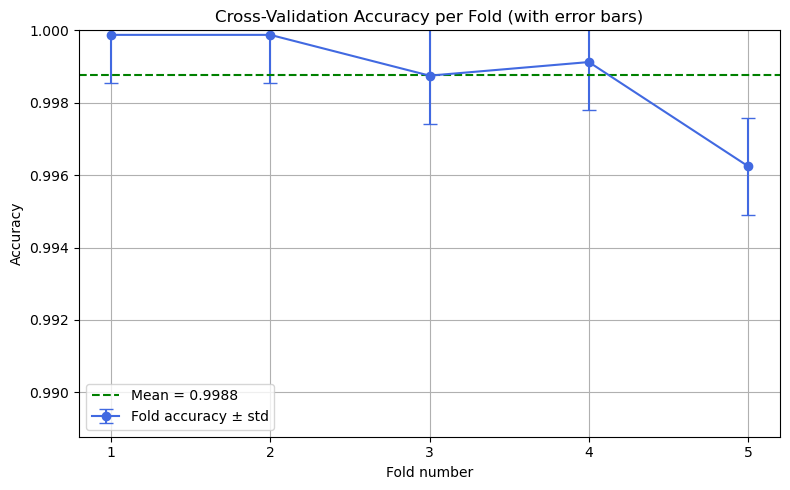

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score


x_vals = np.arange(1, len(scores) + 1)
y_vals = scores
y_mean = np.mean(scores)
y_std = np.std(scores)

plt.figure(figsize=(8, 5))
plt.errorbar(x_vals, y_vals, yerr=y_std, fmt='o-', color='royalblue', capsize=5, label='Fold accuracy ± std')

plt.axhline(y_mean, color='green', linestyle='--', label=f'Mean = {y_mean:.4f}')

plt.title('Cross-Validation Accuracy per Fold (with error bars)')
plt.xlabel('Fold number')
plt.ylabel('Accuracy')
plt.ylim(y_mean - 0.01, 1.0)  
plt.xticks(x_vals)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
